In [1]:
!mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jonathanrjpereira/rice-disease

 56% 2.54G/4.55G [00:27<00:21, 101MB/s] 
User cancelled operation


In [ ]:
!unzip rice-disease.zip

In [ ]:
!pip install split-folders

In [ ]:
!splitfolders --ratio .8 .1 .1 -- data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [17]:
TRAIN_DIR = "output/train"
VAL_DIR = "output/val"
TEST_DIR = "output/test"
CHANNELS = 3
TARGET_SIZE = (224,224)
BATCH_SIZE = 64
EPOCHS = 10

In [18]:
train_ds = train_datagen.flow_from_directory(TRAIN_DIR, target_size = TARGET_SIZE, class_mode = 'sparse', batch_size = BATCH_SIZE)

val_ds = val_datagen.flow_from_directory(VAL_DIR, target_size = TARGET_SIZE, class_mode = 'sparse', batch_size = BATCH_SIZE)

test_ds = test_datagen.flow_from_directory(TEST_DIR, target_size = TARGET_SIZE, class_mode = 'sparse', batch_size = BATCH_SIZE)

Found 4184 images belonging to 4 classes.
Found 520 images belonging to 4 classes.
Found 528 images belonging to 4 classes.


In [19]:
train_ds.class_indices

{'Bacterial Blight': 0, 'Blast': 1, 'Brownspot': 2, 'Tungro': 3}

In [20]:
labels = {0 : 'Bacterialblight', 1 :'Blast', 2 : 'Brownspot' , 3 : 'Tungro'}

In [21]:
class_names = list(train_ds.class_indices)
class_names

['Bacterial Blight', 'Blast', 'Brownspot', 'Tungro']

In [22]:
n_class_names = len(class_names)
n_class_names

4

In [23]:
for image_batch, label_batch in train_ds :
  print(image_batch[0])
  print(label_batch[0])
  print(image_batch[0].shape)
  break

[[[0.08627451 0.1137255  0.        ]
  [0.08627451 0.1254902  0.        ]
  [0.09019608 0.12941177 0.        ]
  ...
  [0.07450981 0.11764707 0.0509804 ]
  [0.07450981 0.11764707 0.0509804 ]
  [0.07450981 0.11764707 0.0509804 ]]

 [[0.28627452 0.33333334 0.13725491]
  [0.2901961  0.3372549  0.14117648]
  [0.2901961  0.34117648 0.13333334]
  ...
  [0.04705883 0.10196079 0.        ]
  [0.04313726 0.10588236 0.        ]
  [0.04313726 0.10588236 0.        ]]

 [[0.58431375 0.6392157  0.40000004]
  [0.58431375 0.6392157  0.40000004]
  [0.5882353  0.6431373  0.4039216 ]
  ...
  [0.09411766 0.16078432 0.02745098]
  [0.08627451 0.16470589 0.01960784]
  [0.08627451 0.16470589 0.01960784]]

 ...

 [[0.5647059  0.7058824  0.32156864]
  [0.54901963 0.6901961  0.30588236]
  [0.54509807 0.6862745  0.3019608 ]
  ...
  [0.2392157  0.3921569  0.12941177]
  [0.2392157  0.39607847 0.12156864]
  [0.2392157  0.39607847 0.12156864]]

 [[0.5647059  0.7058824  0.32156864]
  [0.5529412  0.69411767 0.30980393]


<AxesSubplot:ylabel='count'>

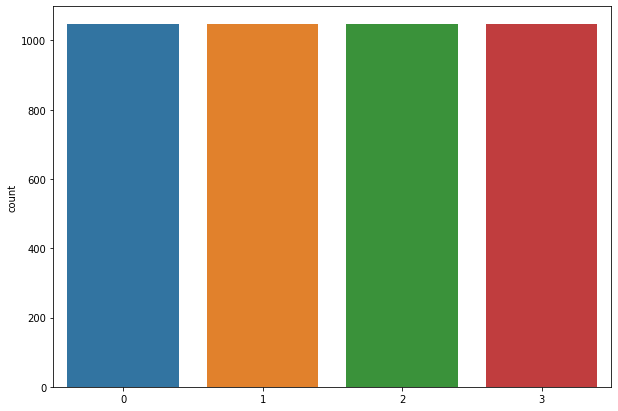

In [24]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.countplot(x = train_ds.classes)

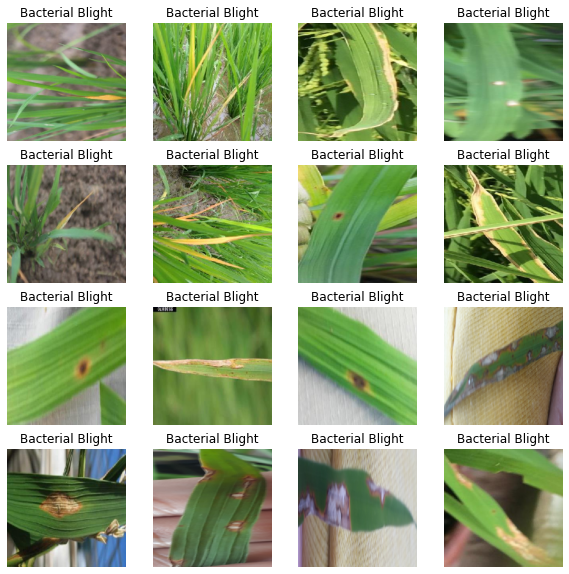

In [25]:
x,y = next(train_ds)

# function to plot images
def plotImages(x,y):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(x[i])
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")
    plt.show()

plotImages(x,y)

In [17]:
!pip install --upgrade tensorflow_hub

You should consider upgrading via the 'c:\users\ikhwa\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [26]:
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
pretrained_model = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5"

base_model = hub.KerasLayer(
    pretrained_model,
    input_shape = (224,224,3),
    trainable = False,
)

In [28]:
METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.Precision(name = 'precision')
]

In [30]:
model = tf.keras.Sequential([
                            base_model,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(n_class_names, activation = 'softmax')
])

model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

callbacks = [
             EarlyStopping(monitor = "val_accuracy", patience = 2),
             ModelCheckpoint("model.h5",monitor = 'val_accuracy', verbose = 1, save_best_only = True)
             ]

history = model.fit(train_ds, 
          epochs = 10, 
          batch_size = BATCH_SIZE, 
          validation_data = val_ds, 
          verbose = 1,
          callbacks = callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1024)              1529968   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4100      
Total params: 1,534,068
Trainable params: 4,100
Non-trainable params: 1,529,968
_________________________________________________________________
Epoch 1/10
66/66 [==============================] - 75s 1s/step - loss: 0.5755 - accuracy: 0.7968 - val_loss: 0.3021 - val_accuracy: 0.9135

Epoch 00001: val_accuracy improved from -inf to 0.91346, saving model to model.h5
Epoch 2/10
66/66 [==============================] - 46s 696ms/step - loss: 0.2049 - accuracy: 0.9587 - val_loss: 0.1717 - val_accuracy: 0.9673

Epo

In [ ]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(224,224,3)),
                            tf.keras.layers.MaxPooling2D((2,2)),
                            tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
                            tf.keras.layers.MaxPooling2D((2,2)),
                            tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
                            tf.keras.layers.MaxPooling2D((2,2)),
                            tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
                            tf.keras.layers.MaxPooling2D((2,2)),
                            tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
                            tf.keras.layers.MaxPooling2D((2,2)),
                            tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
                            tf.keras.layers.MaxPooling2D((2,2)),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(64, activation = 'relu'),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(n_class_names, activation = 'softmax')
])

model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

callbacks = [
             EarlyStopping(monitor = "val_accuracy", patience = 3),
             ModelCheckpoint("model.h5",monitor = 'val_accuracy', verbose = 1, save_best_only = True)
             ]

history = model.fit(train_ds, 
          epochs = 30, 
          batch_size = BATCH_SIZE, 
          validation_data = val_ds, 
          verbose = 1,
          callbacks = callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [31]:
test_scores = model.evaluate(test_ds)

9/9 [==============================] - 7s 786ms/step - loss: 0.0419 - accuracy: 0.9962


In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

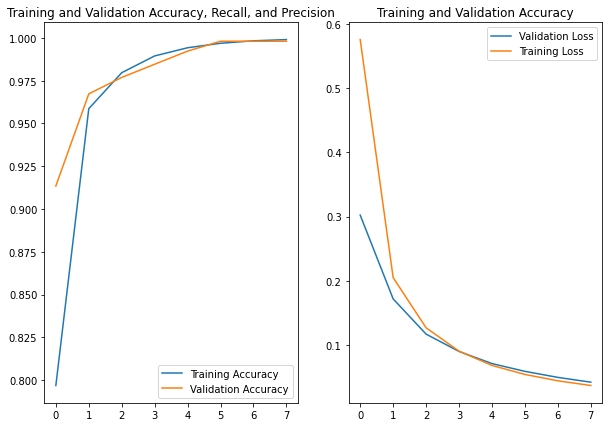

In [34]:
plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(range(8), acc, label = 'Training Accuracy')
plt.plot(range(8), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy, Recall, and Precision')

plt.subplot(1, 2, 2)
plt.plot(range(8), val_loss, label = 'Validation Loss')
plt.plot(range(8), loss, label = 'Training Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

In [35]:
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.models import load_model

# load the best saved model from our last training
myModel = tf.keras.models.load_model("model.h5",custom_objects={'KerasLayer':hub.KerasLayer})

# create a TFLiteConverter object from a TensorFlow Keras model 
converter = tf.lite.TFLiteConverter.from_keras_model(myModel)

# converts a Keras model based on instance variable
myModel_tflite = converter.convert()

# Save the model
tflite_model_file = Path('padiq_classifier_v2.tflite')
tflite_model_file.write_bytes(myModel_tflite)

INFO:tensorflow:Assets written to: C:\Users\ikhwa\AppData\Local\Temp\tmp375e96hn\assets


INFO:tensorflow:Assets written to: C:\Users\ikhwa\AppData\Local\Temp\tmp375e96hn\assets


6209960

In [36]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import tensorflow.lite as tflite
# in AWS Lambda, we need to use this import below
# import tflite_runtime.interpreter as tflite

# Create an interpreter interface for any model in TFLite
interpreter = tflite.Interpreter(model_path='padiq_classifier_v2.tflite')
interpreter.allocate_tensors()

# Get a list of input details from the model
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

# Get a list of output details from the model
output_details = interpreter.get_output_details()
output_index = output_details[0]['index']

labels = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

# Obtain the image location
img_loc = 'output/test/Blast/BLAST1_026.jpg'

# load the image using load_img module
img = load_img(path=img_loc, target_size=(224,224))

# Turn the image into a 4D-array
X = np.expand_dims(img, axis=0)

# Normalize the image
X = X/255.0

# Turn the image into a Numpy array with float32 data type
X = X.astype('float32')


In [37]:
# set the value of the input tensor
interpreter.set_tensor(input_index, X)
interpreter.invoke()

# Get the value of the output tensor
preds = interpreter.get_tensor(output_index)
dict(zip(labels, preds[0]))

{'Bacterialblight': 0.0029604873,
 'Blast': 0.9964786,
 'Brownspot': 0.00048399123,
 'Tungro': 7.698544e-05}

In [45]:
def predict(model,img) :
  img_array = tf.keras.preprocessing.image.img_to_array(images[i])
  img_array = tf.expand_dims(img_array, 0)


  predictions = myModel.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

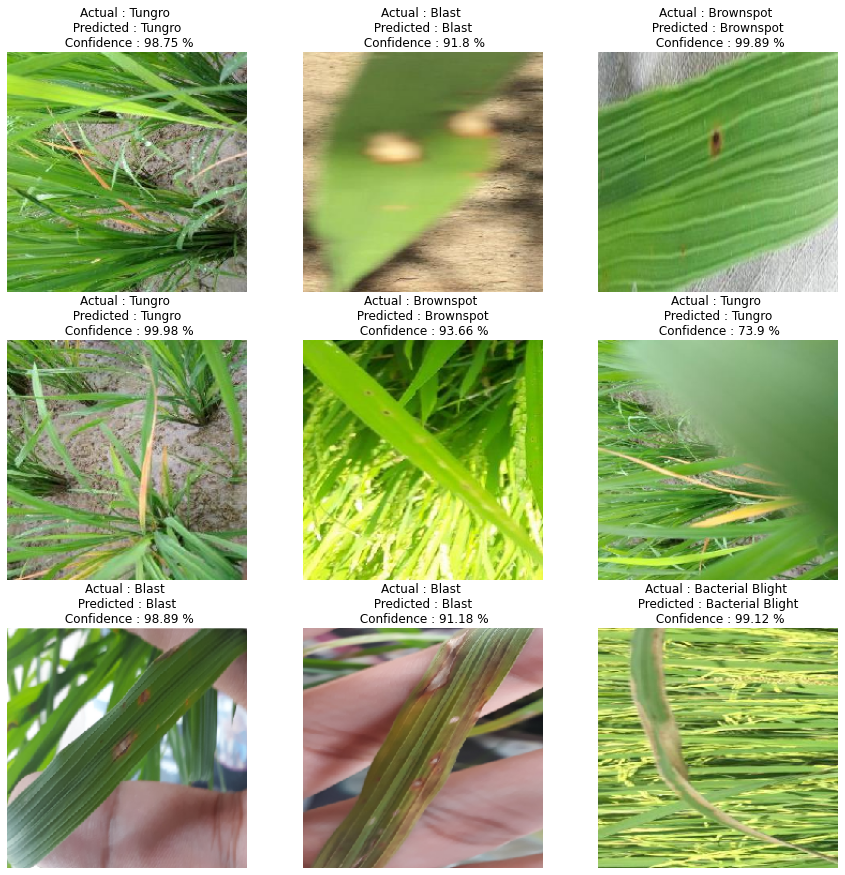

In [49]:
plt.figure(figsize=(15,15))
for images, labels in test_ds :
  for i in range(9) :
    axis = plt.subplot (3,3, i+1)
    plt.imshow(images[i])

    predicted_class, confidence = predict(model,images[i])
    actual_class = class_names[int(labels[i])]

    plt.title(f"Actual : {actual_class} \n Predicted : {predicted_class} \n Confidence : {confidence} %")
    plt.axis("off")
  break